In [1]:
%matplotlib inline

In [66]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
import math

In [3]:
# load data into a table by extracting user and item numbers
ratings = pd.read_csv('../data/data/data_train.csv', dtype={'Prediction': np.int})

How many ratings ?

In [4]:
len(ratings)

1176952

Data structure :

In [5]:
ratings.head()

Id  Prediction
0  r44_c1           4
1  r61_c1           3
2  r67_c1           4
3  r72_c1           3
4  r86_c1           5

In [6]:
ratings.Prediction.max()

5

In [7]:
ratings.Prediction.min()

1

* `Id` is structured as:
    * ri_cj where i is the row number, j is the column number
* Prediction is the rating between 1 and 5

Extract the matrix indices :

In [8]:
idx = ratings.Id.str.extract('r([0-9]+)_c([0-9]+)', expand=True)

In [9]:
idx.head()

0  1
0  44  1
1  61  1
2  67  1
3  72  1
4  86  1

We can now buid the occupancy matrix (it will be sparse !)

In [10]:
user_idx = idx[0].astype(int)
film_idx = idx[1].astype(int)

In [54]:
matrix = np.zeros((max(user_idx), max(film_idx)), dtype=np.int)

In [55]:
for i in range(len(user_idx)):
    matrix[user_idx[i]-1, film_idx[i]-1] = ratings.Prediction[i]

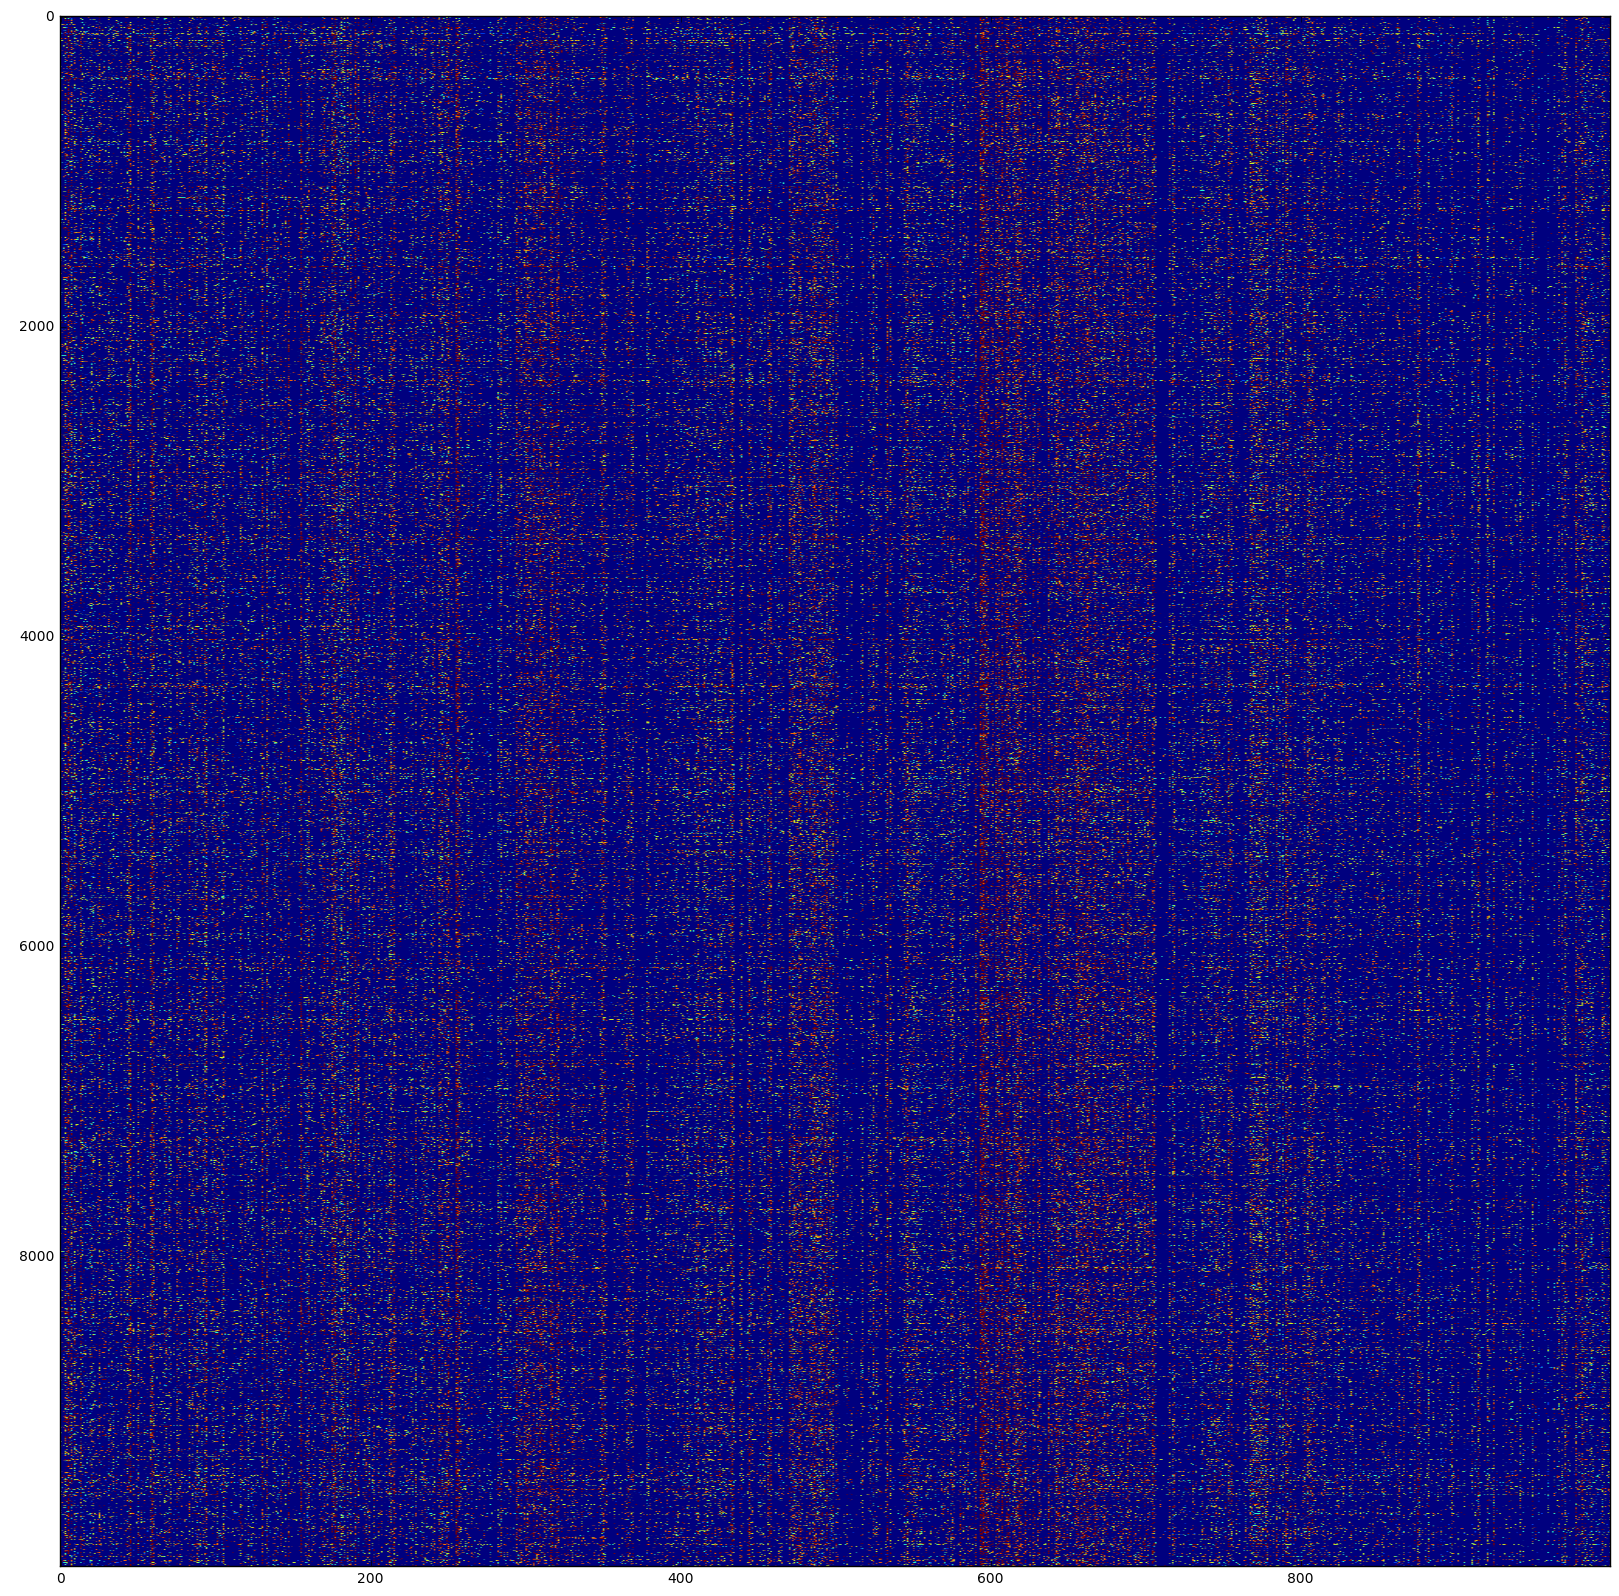

In [13]:
plt.figure(figsize = (20,20))
plt.imshow(matrix, aspect='auto')

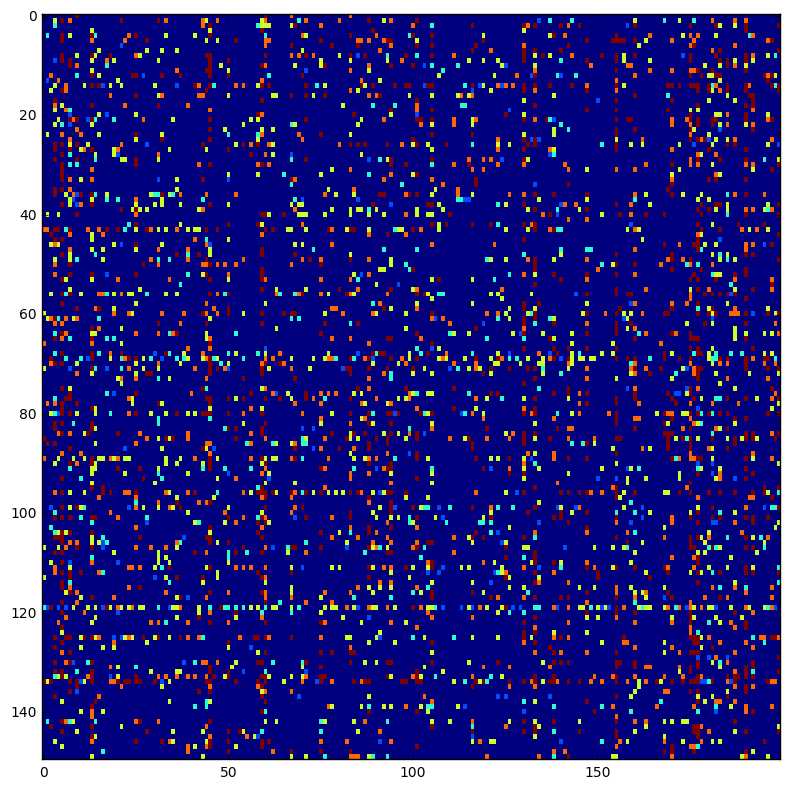

In [14]:
plt.figure(figsize = (8,8))
plt.imshow(matrix[:150, :200], aspect='auto', interpolation='nearest')
plt.tight_layout()

In [15]:
occupancy_stat = np.count_nonzero(matrix) / matrix.size
str(occupancy_stat*100) + ' % occupancy'

'11.76952 % occupancy'

In [16]:
"The data is {} % sparse !".format((1-occupancy_stat)*100)

'The data is 88.23048 % sparse !'

Let's take a subset (1000 movies) to get started prototyping

In [17]:
matrix_subset = matrix[:,:1000]

In [18]:
occupancy_stat = np.count_nonzero(matrix_subset) / matrix_subset.size
str(occupancy_stat*100) + ' % occupancy'

'11.76952 % occupancy'

In [19]:
# Leave one out test / train split
# Adapted from https://gist.github.com/Wann-Jiun/d91f7ccbd20659e9725052a9ac5aed10#file-nycdsa_p5_split-py
train_matrix = matrix_subset.copy()
test_matrix = np.zeros(matrix_subset.shape)
np.random.seed(42)

for i in range(1,len(matrix_subset[0])):
    rating_idx = np.random.choice(
        matrix_subset[i, :].nonzero()[0], 
        size=3)
    train_matrix[i, rating_idx] = 0.0
    test_matrix[i, rating_idx] = matrix_subset[i, rating_idx]
    


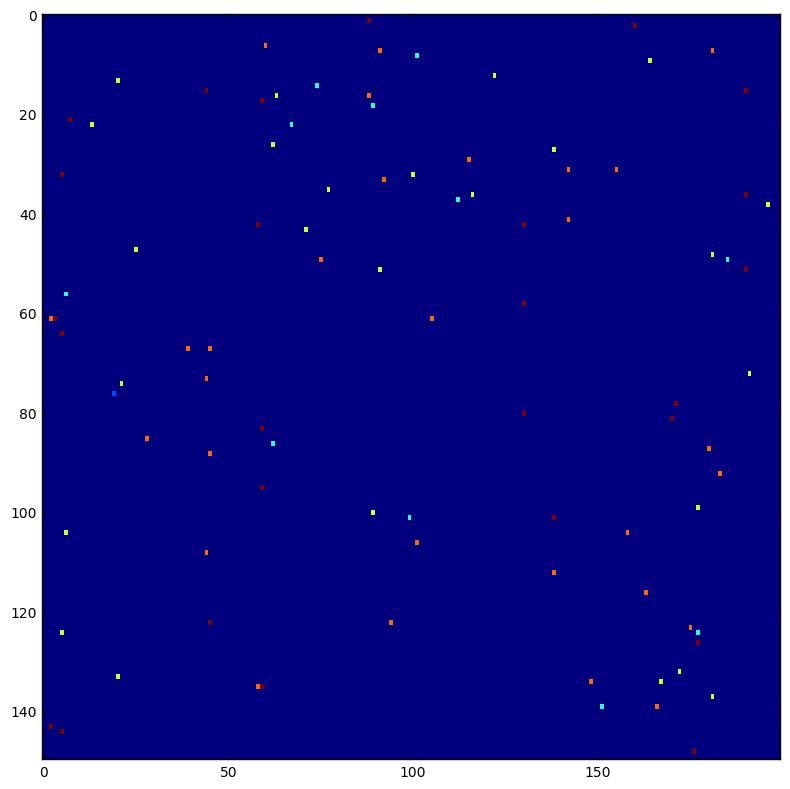

In [20]:
plt.figure(figsize = (8,8))
plt.imshow(test_matrix[:150, :200], aspect='auto', interpolation='nearest')
plt.tight_layout()

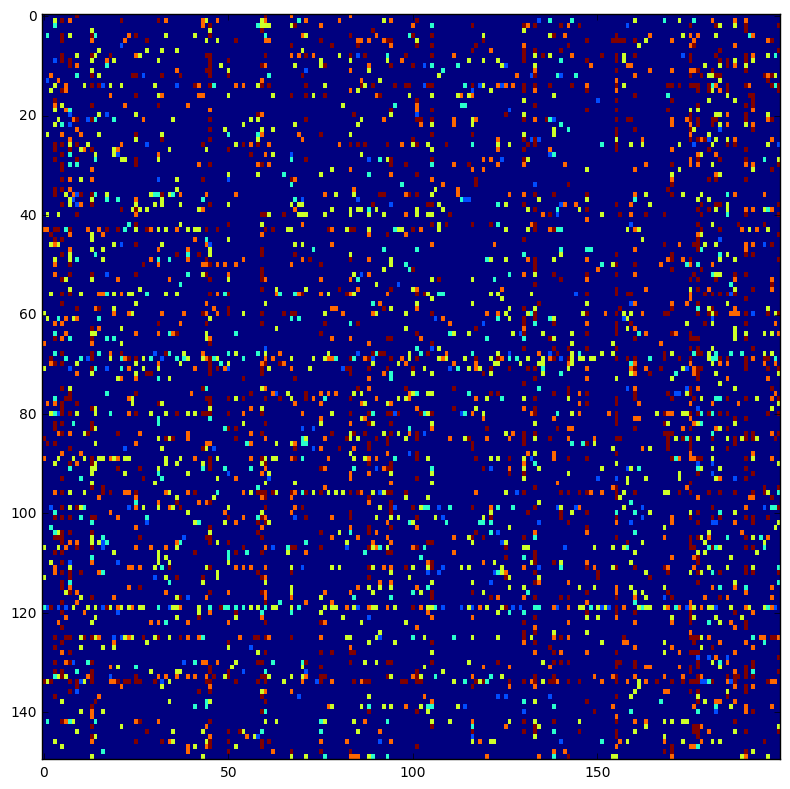

In [21]:
plt.figure(figsize = (8,8))
plt.imshow(train_matrix[:150, :200], aspect='auto', interpolation='nearest')
plt.tight_layout()

## Sample submission csv

In [24]:
submission_ratings = pd.read_csv('../data/data/sampleSubmission.csv', dtype={'Prediction': np.int})

In [25]:
submission_idx = ratings.Id.str.extract('r([0-9]+)_c([0-9]+)', expand=True)

In [26]:
user_idx = submission_idx[0].astype(int)
film_idx = submission_idx[1].astype(int)
sub_matrix = np.zeros((max(user_idx), max(film_idx)), dtype=np.int)
for i in range(len(user_idx)):
    sub_matrix[user_idx[i]-1, film_idx[i]-1] = submission_ratings.Prediction[i]

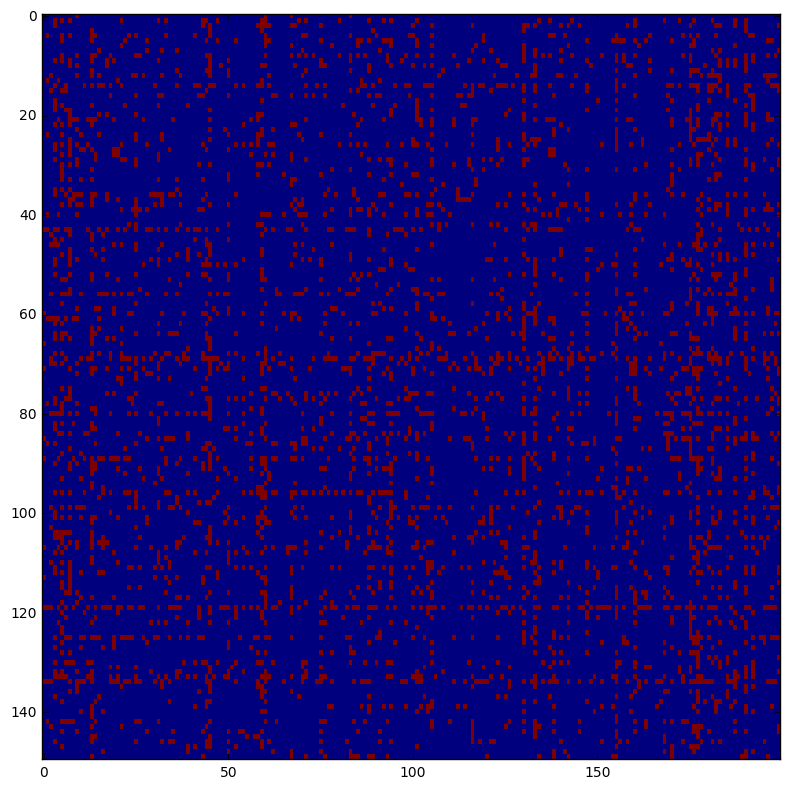

In [27]:
plt.figure(figsize = (8,8))
plt.imshow(sub_matrix[:150, :200], aspect='auto', interpolation='nearest')
plt.tight_layout()

---

# Data Exploration

In [13]:
matrix.shape

# 10000 Users, 1000 Movies

(10000, 1000)

In [20]:
ratings_per_movie = (matrix != 0).sum(0)
ratings_per_user = (matrix != 0).sum(1)

#ratings_per_movie.sort()
# 1% less rated movies
#print(ratings_per_movie[0:10])

#ratings_per_user.sort()
# 1% users who rated the least 
#print(ratings_per_user[0:100])

## Number of ratings 

### Movies
Histrogram + Cumulative distribution function

Mean number of ratings : 1176.952


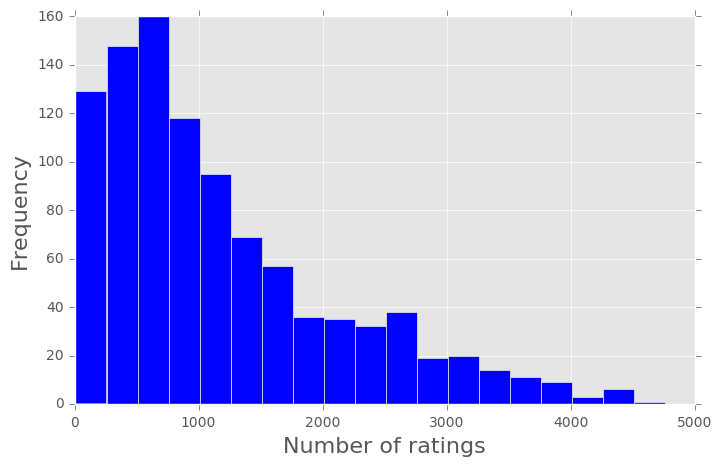

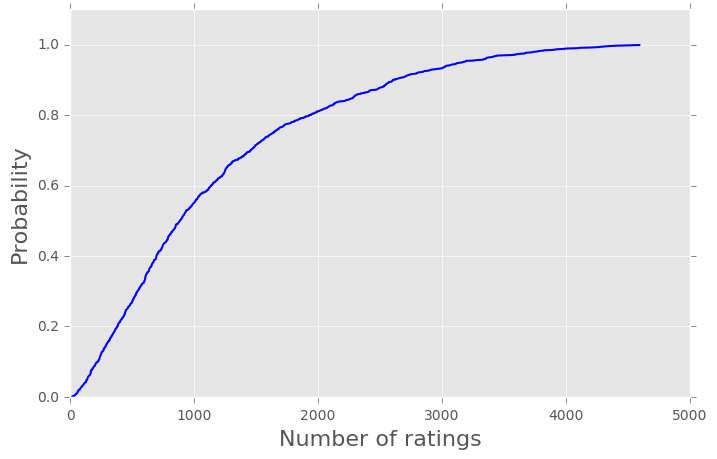

In [86]:
print('Mean number of ratings per movie : %s' % ratings_per_movie.mean())

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(figsize = (8,5))
hist = plt.hist(ratings_per_movie, bins = range(min(ratings_per_movie), max(ratings_per_movie) + 250, 250), color = 'b')
plt.xlabel('Number of ratings', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
fig.savefig('movieshist.jpg')
#plt.show()

###

N = len(ratings_per_movie)
Z = ratings_per_movie
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

fig = plt.figure(figsize = (8,5))
h = plt.plot(X2, F2, c='b', linewidth=1.5)
plt.ylim((0,1.1))
plt.xlabel('Number of ratings', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)
fig.savefig('moviescdf.jpg')
#plt.show()



### Users
Histrogram + Cumulative distribution function

Mean number of ratings per user : 117.6952


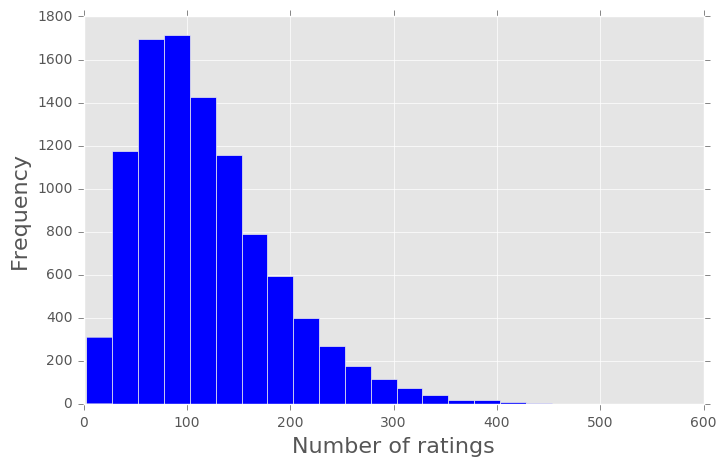

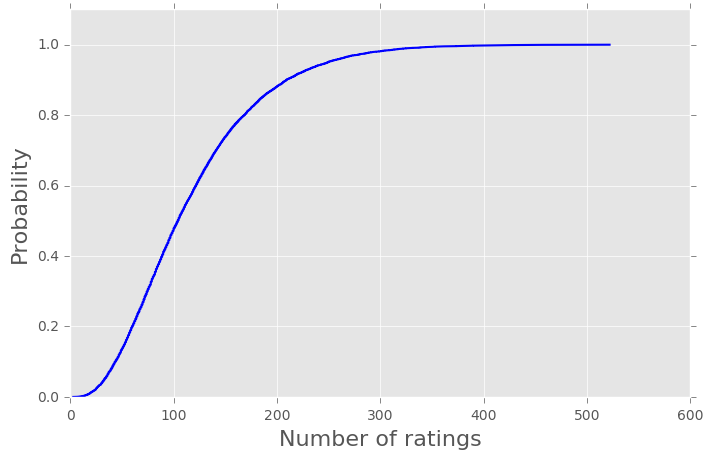

In [87]:
print('Mean number of ratings per user : %s' % ratings_per_user.mean())

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(figsize = (8,5))
hist = plt.hist(ratings_per_user, bins = range(min(ratings_per_user), max(ratings_per_user) + 25, 25), color = 'b')
plt.xlabel('Number of ratings', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
fig.savefig('userhist.jpg')
plt.show()

###

N = len(ratings_per_user)
Z = ratings_per_user
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

fig = plt.figure(figsize = (8,5))
h = plt.plot(X2, F2, c='b', linewidth=1.5)
plt.ylim((0,1.1))
plt.xlabel('Number of ratings', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)
fig.savefig('usercdf.jpg')
plt.show()



## Mean rating per movie

### Investigating is there is a correlation between the rating and the number of rating for a movie

[[ 1.         0.6907119]
 [ 0.6907119  1.       ]]


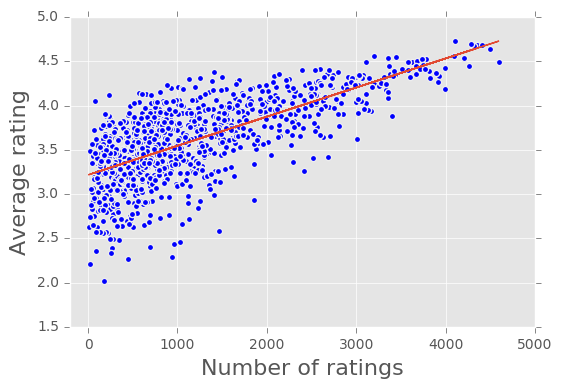

In [24]:
mean_per_movie = matrix.sum(0)/(matrix!=0).sum(0)
ratings_per_movie = (matrix != 0).sum(0)

print(np.corrcoef(ratings_per_movie,mean_per_movie))

h = plt.scatter(ratings_per_movie,mean_per_movie, c='b', linewidth=1)

m, b = np.polyfit(ratings_per_movie,mean_per_movie, 1)
plt.style.use('ggplot')
plt.plot(ratings_per_movie, m*ratings_per_movie + b, '-')
plt.xlim((-200,5000))
plt.xlabel('Number of ratings', fontsize = 16)
plt.ylabel('Average rating', fontsize = 16)

plt.show()

As there seems to be a high correlation, we decide to explore this idea and use it for our predictions :

In [26]:
m, b = np.polyfit(ratings_per_movie,mean_per_movie, 1)
linreg = m*ratings_per_movie + b

In [29]:
matrix2 = matrix

In [30]:
for i in range(10000):
    for j in range(1000):
        if matrix2[i][j] != 0:
            matrix2[i][j] = linreg[j]

In [31]:
predictions = matrix2[test_matrix.nonzero()].flatten()

In [103]:
pred2 = matrix2
for i in range(10000):
    for j in range(1000):
        if pred2[i][j] != 0:
            pred2[i][j] -= difference_to_mean[i]

In [32]:
test_predictions = test_matrix[test_matrix.nonzero()].flatten()

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [38]:
mse = mean_squared_error(predictions, test_predictions)

In [39]:
np.sqrt(mse)

1.1676958137775066

In [104]:
pred2 = matrix2
for i in range(10000):
    for j in range(1000):
        if pred2[i][j] != 0:
            pred2[i][j] -= difference_to_mean[i]

predictions2 = pred2[test_matrix.nonzero()].flatten()

mse2 = mean_squared_error(predictions2, test_predictions)

np.sqrt(mse2)

2.1359218530091781

Not bad but worst than our baselines using mean

In [70]:
mean_per_user = matrix.sum(1)/(matrix!=0).sum(1)
mean_per_user

array([ 4.04347826,  3.77181208,  3.52325581, ...,  3.56097561,
        3.8372093 ,  3.97368421])

In [61]:
print(len(mean_per_user))

10000


In [57]:
n = 0
for i in range(10000):
    for j in range(1000):
        if matrix[i][j] != 0:
            n += matrix[i][j]
n

4539834

In [59]:
avg = 4539834 / 1176952
avg

3.8572805008190647

In [87]:
difference_to_mean = (mean_per_user - avg).tolist()
difference_to_mean
len(difference_to_mean)

10000

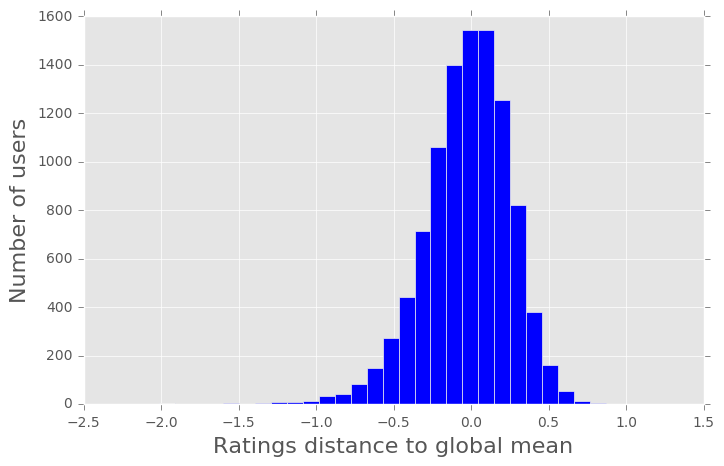

In [86]:
plt.style.use('ggplot')

fig = plt.figure(figsize = (8,5))
hist = plt.hist(difference_to_mean, bins = 30, color = 'b')
plt.xlabel('Ratings distance to global mean', fontsize = 16)
plt.ylabel('Number of users', fontsize = 16)
#plt.xlim = ((-2, 2))
plt.show()
fig.savefig('differencetomean.jpg')

---

Trying out some stuff :)

# Cosine Similarity

The basic idea is to find the similarity between pairs of users and pairs of movies, so when we query for a user/movie pair, it will take information from both classes of similarities.

In more technical terms, we use the similarities as the latent space for users and movies.

In [137]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarities = cosine_similarity(train_matrix) # row wise similarities
movie_similarities = cosine_similarity(train_matrix.transpose()) # column wise similarities

For a user u and a movie i, the prediction is then the weighted sum of similarities with other users * the rating they gave movie i (normalized)

In [29]:
from sklearn.metrics import mean_squared_error # to compute metrics

In [30]:
predictions = user_similarities.dot(train_matrix) / np.array([np.abs(user_similarities).sum(axis=1)]).T

The accuracy metrics only make sense on ratings we know were given (i.e. non zero ratings for the test)

In [31]:
predictions = predictions[test_matrix.nonzero()].flatten()

In [150]:
test_predictions = test_matrix[test_matrix.nonzero()].flatten()

2960


In [33]:
mse = mean_squared_error(predictions, test_predictions)

In [34]:
np.sqrt(mse)

3.104472138584502

We can also do this the other way around : using movie similarities

In [145]:
predictions_movies = movie_similarities.dot(train_matrix.transpose()) / np.array([np.abs(movie_similarities).sum(axis=1)]).T

In [36]:
predictions_movies = predictions_movies[test_matrix.nonzero()].flatten()

In [36]:
mse_movies = mean_squared_error(predictions_movies, test_predictions)

NameError: name 'predictions_movies' is not defined

In [38]:
np.sqrt(mse_movies)

3.4895482026360978

Not as good as with users :) 

---

## Matrix factorisation

In [89]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [90]:
from helpers import load_data, preprocess_data

path_dataset = "../data/data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


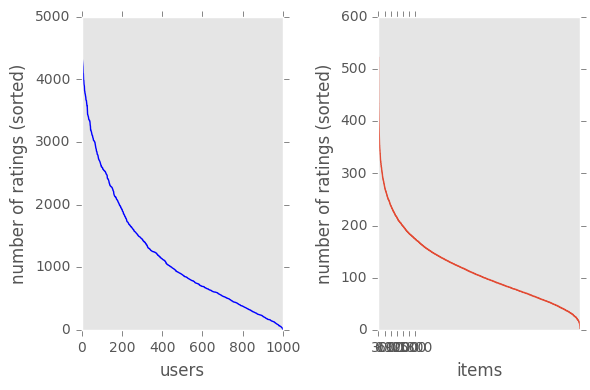

min # of items per user = 8, min # of users per item = 3.


In [94]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [95]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [96]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train, test)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9990, 999)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065253
Total number of nonzero elements in test data:111620


## Baseline with mean

In [9]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()
    #print(global_mean_train)

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

baseline_global_mean(train, test)

3.85811070238
test RMSE of baseline using the global mean: [[ 1.12152228]].


## Baseline with user mean

In [10]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: [[ 1.03317038]].


## Baseline with movie mean

In [47]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: [[ 1.09633198]].


In [12]:
import statistics as stat

## Baseline with median

In [13]:
nonzero_train = train[train.nonzero()]

In [14]:
nonzero_train = list(nonzero_train.T)

In [15]:
len(nonzero_train)

1065253

In [16]:
global_median_train = stat.median(nonzero_train)
print(global_median_train)

  (0, 0)	4.0


In [33]:
m = 4
print(global_median_train.data[0][0])

4.0


In [22]:
from helpers import calculate_mse

def baseline_global_median(train, test, m):
    """baseline method: use the global median."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]
    
    median = m

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, median)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global median: {v}.".format(v=rmse))

baseline_global_median(train, test, m)

test RMSE of baseline using the global median: [[ 1.13154267]].


## Baseline with user median

In [34]:
def baseline_user_median(train, test):
    """baseline method: use the user medians as the prediction."""
    mse = 0
    num_items, num_users = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_median = (stat.median(nonzeros_train_ratings)).data[0][0]
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_median)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user median: {v}.".format(v=rmse))

baseline_user_median(train, test)

test RMSE of the baseline using the user median: [[ 1.47931446]].


## Baseline with movie median

In [36]:
def baseline_item_median(train, test):
    """baseline method: use item medians as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_median = (stat.median(nonzeros_train_ratings)).data[0][0]
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_median)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item median: {v}.".format(v=rmse))
    
baseline_item_median(train, test)

test RMSE of the baseline using the item median: [[ 1.58148726]].


## Matrix factorisation

In [48]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

In [49]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [50]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1188016390962718.
iter: 1, RMSE on training set: 1.055773384636356.
iter: 2, RMSE on training set: 1.035209044732128.
iter: 3, RMSE on training set: 1.0305003556868906.
iter: 4, RMSE on training set: 1.0289338540768067.
iter: 5, RMSE on training set: 1.027541155288929.
iter: 6, RMSE on training set: 1.0267280525334728.
iter: 7, RMSE on training set: 1.0257331157481897.
iter: 8, RMSE on training set: 1.0242128635177157.
iter: 9, RMSE on training set: 1.0250155714728297.
iter: 10, RMSE on training set: 1.0250110976515387.
iter: 11, RMSE on training set: 1.0247649821945568.
iter: 12, RMSE on training set: 1.024444922433812.
iter: 13, RMSE on training set: 1.0243942405531554.
iter: 14, RMSE on training set: 1.0244300096163954.
iter: 15, RMSE on training set: 1.0244421403898754.
iter: 16, RMSE on training set: 1.0243492826217602.
iter: 17, RMSE on training set: 1.0241854571274716.
iter: 18, RMSE on training set: 1.

### Learn the Matrix Factorization using Alternating Least Squares

In [52]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [53]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)


start the ALS algorithm...
RMSE on training set: 2.066790309994609.
RMSE on training set: 1.2730823425316207.
RMSE on training set: 1.1443723965394583.
RMSE on training set: 1.093305613408265.
RMSE on training set: 1.0677955454860306.
RMSE on training set: 1.053327562896735.
RMSE on training set: 1.0444354568715417.
RMSE on training set: 1.0386656716080211.
RMSE on training set: 1.0347770575802662.
RMSE on training set: 1.032084218359697.
RMSE on training set: 1.0301824259196215.
RMSE on training set: 1.0288198573234755.
RMSE on training set: 1.0278332461774837.
RMSE on training set: 1.027113256774244.
RMSE on training set: 1.0265847878082366.
RMSE on training set: 1.0261952239391887.
RMSE on training set: 1.025907136051179.
RMSE on training set: 1.0256935840162407.
RMSE on training set: 1.025535002934475.
RMSE on training set: 1.0254170871091244.
RMSE on training set: 1.025329322370854.
test RMSE after running ALS: 1.0348458103761902.


## SVD

In [159]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error
from math import sqrt

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

AttributeError: flatten not found

In [151]:
def rmse(prediction, ground_truth):
    print(prediction.shape)
    print(ground_truth.shape)
    
    prediction = prediction[ground_truth.nonzero()].flatten()
    print(prediction.shape)
    
    #ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #print(ground_truth.shape)
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    print(ground_truth.shape)
    ground_truth = list(ground_truth.T)
    print(len(ground_truth))
    ground_truth = np.array(ground_truth).flatten()
    print(ground_truth.shape)
    
    return sqrt(mean_squared_error(prediction, ground_truth))


print ('User-based CF MSE: ' + str(rmse(X_pred, test)))

# https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

(9990, 999)
(9990, 999)
(111620,)
(1, 111620)
111620
(111620,)


ValueError: setting an array element with a sequence.